<a href="https://colab.research.google.com/github/brentianpalmer/COVID-19/blob/master/Method_2_LN_LN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [ ]:
#@title
# The primary class for calculating Generalized Black Scholes option prices and deltas
# It is not intended to be part of this module's public interface

# Inputs: option_type = "p" or "c", fs = price of underlying, x = strike, t = time to expiration, r = risk free rate
#         b = cost of carry, v = implied volatility
# Outputs: value, delta, gamma, theta, vega, rho
def _gbs(option_type, fs, x, t, r, b, v):
    # logging.debug("Debugging Information: _gbs()")
    # -----------
    # Test Inputs (throwing an exception on failure)
    # _gbs_test_inputs(option_type, fs, x, t, r, b, v)

    # -----------
    # Create preliminary calculations
    t__sqrt = math.sqrt(t)
    d1 = (math.log(fs / x) + (b + (v * v) / 2) * t) / (v * t__sqrt)
    d2 = d1 - v * t__sqrt

    if option_type == "c":
        # it's a call
        # logging.debug("     Call Option")
        value = fs * math.exp((b - r) * t) * norm.cdf(d1) - x * math.exp(-r * t) * norm.cdf(d2)
        delta = math.exp((b - r) * t) * norm.cdf(d1)
        gamma = math.exp((b - r) * t) * norm.pdf(d1) / (fs * v * t__sqrt)
        theta = -(fs * v * math.exp((b - r) * t) * norm.pdf(d1)) / (2 * t__sqrt) - (b - r) * fs * math.exp(
            (b - r) * t) * norm.cdf(d1) - r * x * math.exp(-r * t) * norm.cdf(d2)
        vega = math.exp((b - r) * t) * fs * t__sqrt * norm.pdf(d1)
        rho = x * t * math.exp(-r * t) * norm.cdf(d2)
    else:
        # # it's a put
        # logging.debug("     Put Option")
        value = x * math.exp(-r * t) * norm.cdf(-d2) - (fs * math.exp((b - r) * t) * norm.cdf(-d1))
        delta = -math.exp((b - r) * t) * norm.cdf(-d1)
        gamma = math.exp((b - r) * t) * norm.pdf(d1) / (fs * v * t__sqrt)
        theta = -(fs * v * math.exp((b - r) * t) * norm.pdf(d1)) / (2 * t__sqrt) + (b - r) * fs * math.exp(
            (b - r) * t) * norm.cdf(-d1) + r * x * math.exp(-r * t) * norm.cdf(-d2)
        vega = math.exp((b - r) * t) * fs * t__sqrt * norm.pdf(d1)
        rho = -x * t * math.exp(-r * t) * norm.cdf(-d2)

    # logging.debug("     d1= {0}\n     d2 = {1}".format(d1, d2))
    # logging.debug("     delta = {0}\n     gamma = {1}\n     theta = {2}\n     vega = {3}\n     rho={4}".format(delta, gamma,
    #                                                                                                     theta, vega,
    #                                                                                                     rho))

    return value, delta, gamma, theta, vega, rho



def black_76(option_type, fs, x, t, r, v):
    """Commodity option pricing.
    The Black 76 model is for an option where the underlying commodity is traded
    based on a future price rather than a spot price. Instead of dealing with a
    spot price that drifts upwards at the risk free rate, this model deals with
    a forward price that needs to be present valued.
    Args:
        option_type (str): Type of the option. "p" for put and "c" for call options.
        fs (float): Price of underlying asset.
        x (float): Strike price.
        t (float): Time to expiration in years. 1 for one year, 0.5 for 6 months.
        r (float): Risk free rate.
        v (float): Implied volatility of underlying asset.
    Returns:
        value (float): Price of the option.
        delta (float): First derivative of value with respect to price of underlying.
        gamma (float): Second derivative of value w.r.t price of underlying.
        theta (float): First derivative of value w.r.t. time to expiration.
        vega (float): First derivative of value w.r.t. implied volatility.
        rho (float): First derivative of value w.r.t. risk free rates.
    """
    b = 0
    return _gbs(option_type, fs, x, t, r, b, v)

# Black Scholes: stock Options (no dividend yield)
def black_scholes(option_type, fs, x, t, r, v):
    b = r
    return _gbs(option_type, fs, x, t, r, b, v)

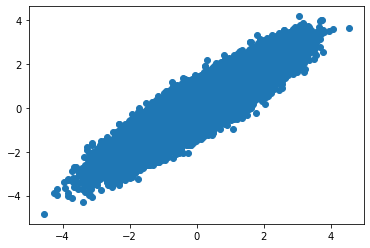

In [ ]:
#@title
# Generating Correlated Random Samples from Normal distribution from Hull Chapter 21
Nsim = 100000
rho_sl = 0.9
rand1 = np.random.normal(0,1,Nsim) # random sample from standard normal dist
rand2 = np.random.normal(0,1,Nsim) # another random sample from different standard normal dist
eps = rand1 # eps for stock lognormal simulation
eps_tilda = (rho_sl*rand1)+rand2*np.sqrt(1-rho_sl**2) # eps for libor lognormal simulation
plt.scatter(eps,eps_tilda)

# Method II: Equity Log-normal, Libor Log-Normal

### Model Parameters

In [ ]:
# -------- Initial Values --------- # 
S0 = 271.27211906501435 # equity_initial_value NI225 quote today: 29518.3400, converted to USD: 29518.3400  / 108.8145
q = 0.0 # Ni225 pays no div
r_f = -0.00138 # Japan 3 year government bond yield (from market data (3yr yield)
delta = 0.25
T = 3.0

# -------- Correlations --------- #  
# Correlation stock and exchange rate #
rho_sx = -0.3049678 # correl (NI225 in USD, USD/JPY (DOM exchange rate))

# Correlation stock and bond #
rho_sp = -0.65 # Correl (NI225 in USD, bond maturing in 3 years) *** THIS IS MADE UP *** 
# (maybe pull from nikkei in USD and r_f???)

## Correlation stock and libor #
rho_sl = 0.65 # Correl (NI225 in USD, Libor) *** THIS IS MADE UP ***

# ** IMPORTANT ** 
# rho_sl and rho_sp are linked, but they are not the same
# need to comment / research relationship
# perhaps can assume rho_sl = -rho_sp  
# ** IMPORTANT **

# -------- Volatilities --------- #  
sigma_s = 0.199468950979314 # Volatility of NI225 in USD
sigma_x = 0.0519824811701589  # Volatility of USD/JPY (DOM exchange rate).
sigma_l = 0.08 # Libor Vol *** THIS IS MADE UP ***
sigma_p = 0.05 # vol of the bond that is 3 years *** THIS IS MADE UP *** 

### Equity Log-normal Model

In [ ]:
# quanto adjustment = r_f - q - rho_sx sigma_s sigma_x 
quanto_adj = r_f - q - rho_sx * sigma_s * sigma_x

girsanov_chg_measure_QT = sigma_s * sigma_p * rho_sp

# Process for Generating Correlated Random Samples from Normal distribution from Hull Chapter 21
np.random.seed(456)
Nsim = 10000
rand1 = np.random.normal(0,1,Nsim) # random sample from standard normal dist
rand2 = np.random.normal(0,1,Nsim) # another random sample from different standard normal dist

eps = rand1 # eps for stock lognormal simulation
eps_tilda = (rho_sl*rand1)+rand2*np.sqrt(1-rho_sl**2) # eps for libor lognormal simulation

# As a result, we now can simulate ST with a one-step monte carlo as follows:
ST = S0 * np.exp((quanto_adj + girsanov_chg_measure_QT-0.5*sigma_s*sigma_s)*T + sigma_s*np.sqrt(T)*eps) # The MC scheme with vectorized NumPy code handling all paths at once.
ST_avg = np.average(ST)

ST_over_S0 = ST/S0
ST_over_S0_avg = np.average(ST_over_S0)


ST mean:  267.35730895270837


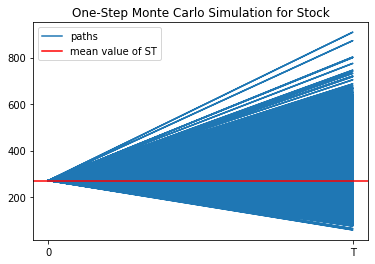

In [ ]:
#@title
# Chart for 1 step MC simulation of equity price ST
x=[]
y=[]
for i in ST:
    y.append(i)
    y.append(S0)
    x.append(1)            
    x.append(0)            
    
plt.title("One-Step Monte Carlo Simulation for Stock")
plt.plot(x, y, label='paths')
plt.axhline(ST.mean(), color='r', label='mean value of ST')
plt.legend(loc='upper left')
plt.xticks()
plt.xticks(np.arange(0, 1.1, step=1))
plt.xticks([0, 1],['0','T'])
print("ST mean: ", ST.mean())

ST_avg:  267.35730895270837
ST_over_S0_avg (ST/S0):  0.9855686971230251
Stock Portion of Payoff ((ST/S0)- k, where k=1):  -0.014431302876974916


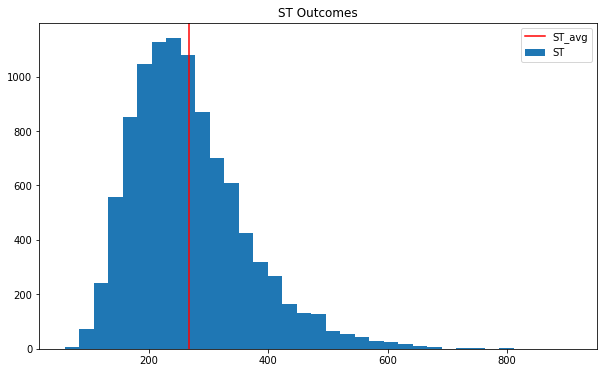

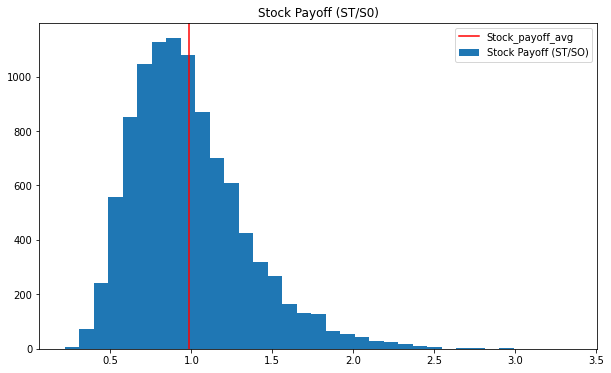

In [ ]:
#@title
plt.figure(figsize=(10, 6))
plt.hist(ST, bins=35, label='ST')
plt.axvline(ST_avg, color='r', label='ST_avg')
plt.title("ST Outcomes")
plt.legend(loc=0)
print("ST_avg: " , ST_avg)
plt.legend(loc=0)

plt.figure(figsize=(10, 6))
plt.hist(ST_over_S0, bins=35, label='Stock Payoff (ST/SO)')
plt.title("Stock Payoff (ST/S0)")
plt.axvline(ST_over_S0_avg, color='r', label='Stock_payoff_avg')
plt.legend(loc=0)
print("ST_over_S0_avg (ST/S0): ", ST_over_S0_avg)
plt.legend(loc=0)
print("Stock Portion of Payoff ((ST/S0)- k, where k=1): ", ST_over_S0_avg-1)
print:("\n")

In [ ]:
#@title
class ForwardRates(object):

    def __init__(self):
        self.forward_rates = []
        self.spot_rates = dict()

    def add_spot_rate(self, T, spot_rate):
        self.spot_rates[T] = spot_rate

    def get_forward_rates(self):
        """
        Returns a list of forward rates
        starting from the second time period.
        """
        periods = sorted(self.spot_rates.keys())
        for T2, T1 in zip(periods, periods[1:]):
            forward_rate = self.calculate_forward_rate(T1, T2)
            self.forward_rates.append(forward_rate)

        return self.forward_rates

    def calculate_forward_rate(self, T1, T2):
        R1 = self.spot_rates[T1]
        R2 = self.spot_rates[T2]
        forward_rate = (R2*T2-R1*T1)/(T2-T1)
        return forward_rate

In [ ]:
#@title
fr = ForwardRates()
merged_list = tuple(zip(xp, yp))
merged_list

for i in merged_list:
  fr.add_spot_rate(i[0],i[1])

my_fr = fr.get_forward_rates()
my_fr_copy = my_fr.copy()
my_fr_copy.insert(0,0)

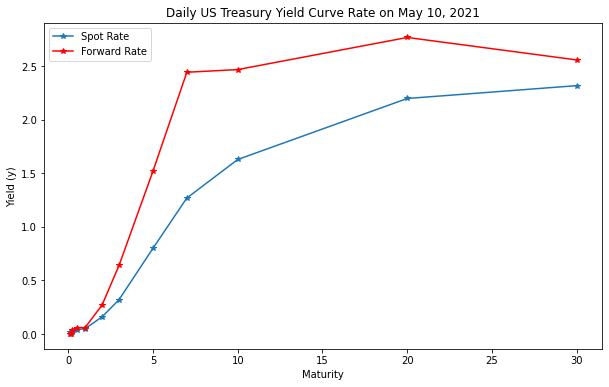

In [ ]:
#@title
plt.figure(figsize=(10, 6))
plt.plot(xp,yp, '-*', label='Spot Rate')
plt.plot(xp,my_fr_copy, '-*', color='r', label='Forward Rate')
plt.title("Daily US Treasury Yield Curve Rate on May 10, 2021")
plt.xlabel('Maturity')
plt.ylabel('Yield (y)')
plt.legend(loc=0)

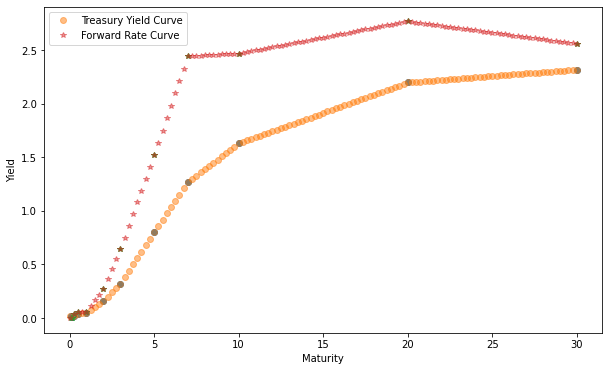

In [ ]:
#@title
x_hat = np.arange(0, 30.25, 0.25)
y_interp = np.interp(x_hat, xp, yp)
y_fr_interp = np.interp(x_hat,xp,my_fr_copy)
# print(x_hat)

# points = xp
# values = yp
# x= x_hat
# y = y_interp

plt.figure(figsize=(10, 6))
plt.plot(xp, yp, 'o')
plt.plot(x_hat, y_interp, 'o', alpha=0.5, label='Treasury Yield Curve')
plt.plot(xp, my_fr_copy, '*')
plt.plot(x_hat, y_fr_interp, '*', alpha=0.5, label="Forward Rate Curve")
plt.legend(loc=0)
plt.xlabel("Maturity")
plt.ylabel("Yield");

In [ ]:
#@title
# Calculate L0, which is f(0,T)

# Start with Daily US Treasury Yield Curve Rate on May 10, 2021
# Date	1 Mo	2 Mo	3 Mo	6 Mo	1 Yr	2 Yr	3 Yr	5 Yr	7 Yr	10 Yr	20 Yr	30 Yr
# 05/10/21	0.02	0.01	0.02	0.04	0.05	0.16	0.32	0.80	1.27	1.63	2.20	2.32
# Source: https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield

xp = [1.0/12, 2.0/12, 3.0/12, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]
yp = [0.02,	0.01,	0.02,	0.04,	0.05,	0.16,	0.32,	0.80,	1.27,	1.63,	2.20,	2.32]

In [ ]:
ytm1 = 0.32 # yield on 3Y treasury; used to calculate p(0,T), where T=3 yrs. 
# ytm1 = 0.32, yield on 3Y treasury
print ("ytm1:", ytm1)

ytm2 = np.interp(T-delta, xp, yp) #yield to maturity for T-delta (2.75 months here)
print ("ytm2:", ytm2)
p_0T = 1.0/(1+ytm1/100)**T #price of p(0,T)
p_0Td = 1.0/(1+ytm2/100)**(T-delta) #price of p(0,T-delta)

print("p_0T: ",p_0T,)
print("p_0Td: ", p_0Td)

ytm1: 0.32
ytm2: 0.28
p_0T:  0.9904611138858473
p_0Td:  0.9923402465011337


In [ ]:
# L0 from Treasury YC via NS method:
# L0 = f(0,T)
L0 = 0.0034

In [ ]:
L_Td = L0 * np.exp(sigma_l * np.sqrt(T - delta) * eps_tilda - 0.5*sigma_l*sigma_l*(T-delta))
L_Td_avg = np.average(L_Td)

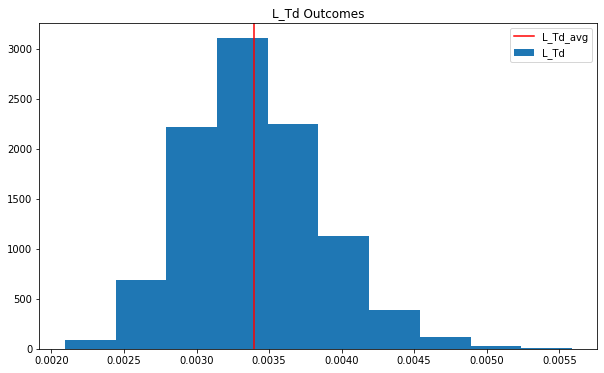

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(L_Td,  label='L_Td')
plt.axvline(L_Td_avg, color='r', label='L_Td_avg')
plt.title("L_Td Outcomes")
plt.legend(loc=0)

In [ ]:
p_temp1 = p_0T + L_Td * delta * p_0T

In [ ]:
p_temp2 = np.zeros_like(p_temp1)
p_temp2 = p_0T/p_0Td

In [ ]:
#Libor portion of final payoff
#p(T-Delta,T) and p(0,T-Delta) are both input from the simulated Libor portion
def L_portion(pTdT, p_0Td):
    return ((1-pTdT)*(p_0T))/(pTdT*(p_0Td-p_0T))

L_portion = L_portion(p_temp2, p_temp1)
L_portion_avg = np.average(L_portion)
L_portion_avg

2.272674493955732

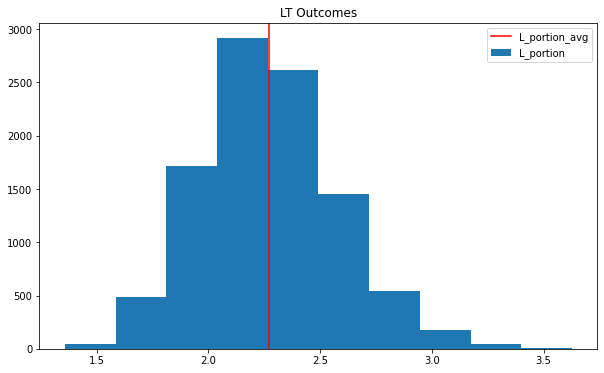

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(L_portion, label='L_portion')
plt.axvline(L_portion_avg, color='r', label='L_portion_avg')
plt.title("LT Outcomes")
plt.legend(loc=0)

In [ ]:
S0_denom = np.ones_like(ST)*S0

Average payoff is: 0.2156762871315974


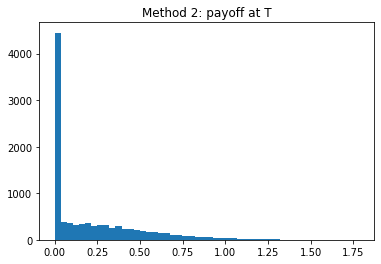

In [ ]:
k_stock_lognormal = 1
k_libor_lognormal = 1
pi = np.maximum(0, np.multiply((ST/S0_denom - k_stock_lognormal), (k_libor_lognormal-L_portion)))
plt.hist(pi,bins=50)
plt.title("Method 2: payoff at T")
print("Average payoff is:", np.average(pi))

In [ ]:
price = p_0T * np.average(pi)
print(price)

0.2136189755911258
